In [1]:
from collections import Counter
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import re
from sklearn.model_selection import GroupKFold


warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_using_cv(
        dataset: pd.DataFrame,
        kfold_params: Dict,
        outputs_dir: pathlib.Path,
    ):
    
    kfold = GroupKFold(**kfold_params)
    target_columns = ['target']
    feature_columns = [
        col for col in dataset.columns
        if col not in ['date_id', 'target', 'time_id', 'row_id']
    ]
    groups = dataset['stock_id']
    oof_true = []
    oof_pred = []
    fimps = []
    best_param_records = {}
    best_value_records = {}
    for k, (train_indices, valid_indices) in enumerate(kfold.split(dataset, groups=groups)):
        print(f'fold {k+1}')

        train_X = dataset.iloc[train_indices][feature_columns].values
        train_y = dataset.iloc[train_indices][target_columns].values.reshape(-1)
        valid_X = dataset.iloc[valid_indices][feature_columns].values
        valid_y = dataset.iloc[valid_indices][target_columns].values.reshape(-1)
        print(train_X.shape, train_y.shape)
        print(valid_X.shape, valid_y.shape)
        
        best_param_records[f'fold{k+1}'] = {}
        best_value_records[f'fold{k+1}'] = {}

        objective = Objective(train_X, train_y, valid_X, valid_y)
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=10)
        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)

        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(train_X, train_y)
        valid_dataset = lgb.Dataset(valid_X, valid_y)
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,

        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_group_fold{k+1}'),
            num_iteration=model.best_iteration
        )

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)
        
        oof_true.append(valid_y)
        oof_pred.append(model.predict(valid_X))
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    display(fimps)
    
    fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3)
    plt.show()
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    oof_mae = np.mean(abs(oof_true - oof_pred))
    print(f'oof mae: {oof_mae:.4f}')
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'oof rmse': oof_mae.item(),
            },
            f,
            default_flow_style=False
        )


class Objective:
    def __init__(self, train_X, train_y, valid_X, valid_y):
        self.train_X = train_X
        self.train_y = train_y
        self.valid_X = valid_X
        self.valid_y = valid_y

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            #'num_leaves': trial.suggest_int('max_depth', 31, 127),
            'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0),
            'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.2, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        train_dataset = lgb.Dataset(self.train_X, self.train_y)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=trial.suggest_int('num_boost_round', 500, 3000),
        )

        preds = model.predict(self.valid_X)
        mae = np.mean(abs(preds - self.valid_y))
        return mae

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_ez.csv'))
train_ez_df = train_ez_df.dropna(subset=['target'])
display(train_ez_df)

train_not_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_not_ez.csv'))
train_not_ez_df = train_not_ez_df.dropna(subset=['target'])
train_not_ez_df['diff_ask_bid_price'] = train_not_ez_df['ask_price'] - train_not_ez_df['bid_price']
train_not_ez_df['sum_ask_bid_price'] = train_not_ez_df['ask_price'] + train_not_ez_df['bid_price']
train_not_ez_df['diff_ask_bid_size'] = train_not_ez_df['ask_size'] - train_not_ez_df['bid_size']
train_not_ez_df['sum_ask_bid_size'] = train_not_ez_df['ask_size'] + train_not_ez_df['bid_size']
display(train_not_ez_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
2,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
3,9,0,0,3039700.65,-1,1.000969,6248958.45,NaN,NaN,0.999354,6191.00,1.000646,6199.00,1.000000,7.970333,0,0_0_9
4,10,0,0,10482752.19,-1,1.001374,8839457.10,NaN,NaN,0.999885,18802.00,1.001321,217098.37,1.000000,5.350113,0,0_0_10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642164,192,480,540,67162.62,1,1.000762,11790079.43,1.000834,1.000762,1.000545,168412.86,1.000762,69841.50,1.000698,-1.729727,26454,480_540_192
2642165,193,480,540,6500948.04,1,1.001599,80357531.06,1.002908,1.002326,1.001454,413142.24,1.001599,363532.53,1.001531,-3.880262,26454,480_540_193
2642166,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
2642167,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,diff_ask_bid_price,sum_ask_bid_price,diff_ask_bid_size,sum_ask_bid_size
0,1,0,0,166603.91,-1,0.999896,1.642214e+06,NaN,NaN,0.999896,...,1.000660,20605.09,1.000000,-5.519986,0,0_0_1,0.000764,2.000556,17372.05,23838.13
1,2,0,0,302879.87,-1,0.999561,1.819368e+06,NaN,NaN,0.999403,...,1.000298,18995.00,1.000000,-8.389950,0,0_0_2,0.000895,1.999701,-18961.00,56951.00
2,5,0,0,0.00,0,1.000635,1.355288e+07,NaN,NaN,0.999779,...,1.000635,5647.65,1.000000,6.779432,0,0_0_5,0.000856,2.000414,3684.93,7610.37
3,6,0,0,969969.40,1,1.000115,3.647504e+06,NaN,NaN,0.999506,...,1.000283,3810.48,1.000000,-2.499819,0,0_0_6,0.000777,1.999789,-2852.68,10473.64
4,7,0,0,9412959.10,1,0.999818,2.126125e+07,NaN,NaN,0.999741,...,1.000130,2570.60,1.000000,-1.959801,0,0_0_7,0.000389,1.999871,-2568.60,7709.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595718,190,480,540,466320.15,-1,0.999295,3.929472e+07,0.998983,0.999139,0.999295,...,0.999451,169105.20,0.999311,-0.470281,26454,480_540_190,0.000156,1.998746,149379.34,188831.06
2595719,191,480,540,36937785.44,1,0.995983,6.083261e+08,0.999086,0.997746,0.995913,...,0.995983,48025.00,0.995958,0.799894,26454,480_540_191,0.000070,1.991896,-36719.00,132769.00
2595720,194,480,540,262271.52,-1,1.001504,3.922295e+06,1.000677,1.000677,1.001504,...,1.001917,139637.49,1.001557,4.839897,26454,480_540_194,0.000413,2.003421,118808.29,160466.69
2595721,197,480,540,0.00,0,0.995789,1.272544e+07,0.995789,0.995789,0.995789,...,0.995883,180038.32,0.995797,1.169443,26454,480_540_197,0.000094,1.991672,163247.66,196828.98


fold 1


[I 2023-10-19 02:54:57,577] A new study created in memory with name: no-name-23f81d0b-a02e-4528-9a8d-1bfaa8e8a802


(2076798, 17) (2076798,)
(518925, 17) (518925,)
2076798
518925
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[882]	train's l1: 7.86384	valid's l1: 7.48257
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2925]	train's l1: 7.89821	valid's l1: 7.49106
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1145]	train's l1: 7.87084	valid's l1: 7.48683
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1410]	train's l1: 7.86846	valid's l1: 7.4911
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[614]	train's l1: 7.86584	valid's l1: 7.48391
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1103]	train's l1: 7.86288	valid's l1: 7.48107
Training until validatio

,fold1,fold2,fold3,fold4,fold5,mean_fimps,std_fimps
sum_ask_bid_price,8992.475992,20101.957046,19781.391828,12048.005604,11106.587170,14406.083528,5174.245566
bid_price,12228.813457,20918.540278,23713.114026,13576.938716,12589.280596,16605.337414,5328.650868
ask_price,13792.932023,21334.315259,22155.394221,14800.941902,13502.844712,17117.285623,4261.655646
imbalance_buy_sell_flag,16753.369598,17086.253634,19817.971391,17244.170750,15161.239554,17212.600986,1675.103910
far_price,14765.280812,23894.867211,26579.081509,19608.232196,17244.952181,20418.482782,4814.683800
sum_ask_bid_size,6728.490060,44225.630678,39439.161019,12635.883503,6206.483232,21847.129698,18495.452245
wap,17271.664483,36471.530053,33125.293145,19341.012523,18229.892672,24887.878575,9153.403694
near_price,23245.556486,30531.402327,30389.569389,25157.342281,23121.689595,26489.112016,3714.413667
reference_price,27651.811526,33997.738447,30283.223920,25062.020365,27185.223364,28836.003524,3431.773922
stock_id,24393.030429,39114.882729,39539.095337,31412.001338,23010.418165,31493.885600,7829.480600


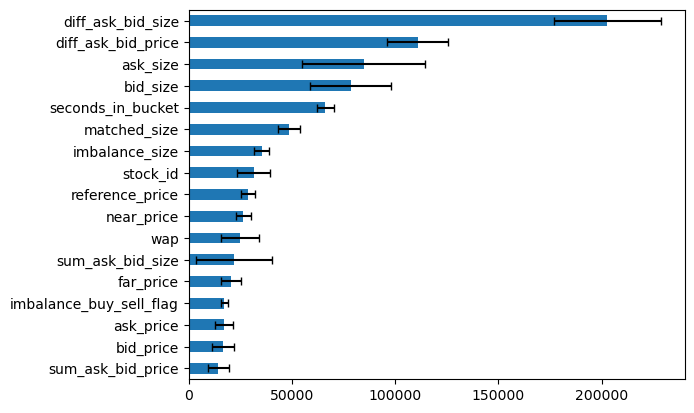

oof mae: 7.8418


In [4]:
kfold_params = {
    'n_splits': 5,
}

train_using_cv(
    kfold_params=kfold_params,
    dataset=train_not_ez_df,
    outputs_dir=outputs_dir_path,
)